 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 6. MLP Basis**
# Section 7. BackPropagation Implementation

### _Objective_
1. Numpy를 통해, BackPropagation을 구현해 보도록 하겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## 예제 데이터 ) 암 환자 데이터 셋

In [26]:
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
cancer_df = pd.read_csv('cancer_dataset.csv')

--2019-05-17 02:19:11--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.56.41
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.56.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2958 (2.9K) [text/csv]
Saving to: ‘cancer_dataset.csv.1’

cancer_dataset.csv. 100%[===================>]   2.89K  --.-KB/s    in 0s      

2019-05-17 02:19:12 (126 MB/s) - ‘cancer_dataset.csv.1’ saved [2958/2958]



In [27]:
cancer_df.describe()
#cancer_df.sample(5)
labels = cancer_df["label"]
xs = cancer_df.iloc[:,:-1]
xs.sample(2)
cancer_df.describe()
cancer_df = (cancer_df - cancer_df.min()) / (cancer_df.max() - cancer_df.min())
cancer_df.describe()
xs = cancer_df.iloc[:,:-1]
print(xs.describe())
xs = xs.values
#print(xs)
#xs = np.array(xs)
#print(xs.shape[0])
#labels


              age  tumor_size
count  100.000000  100.000000
mean     0.405840    0.362107
std      0.212474    0.215413
min      0.000000    0.000000
25%      0.245878    0.206939
50%      0.365621    0.295774
75%      0.535219    0.500765
max      1.000000    1.000000


### 데이터 시각화

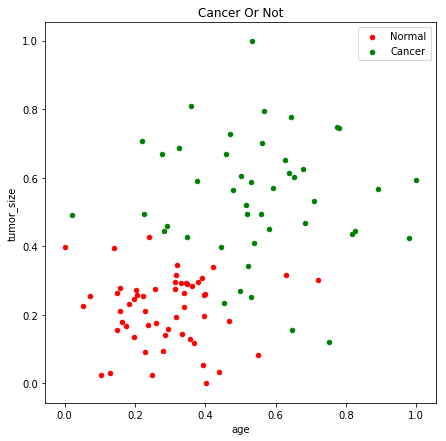

In [28]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
cancer_df[cancer_df.label==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
cancer_df[cancer_df.label==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

<br><br>

# \[ 1. 2층 신경망 구현하기 \]

----

----

> *Chapter 3에서 구현하였던 2층짜리 신경망을 구현해 보도록 하겠습니다. *<br>


<br>

## 1. Layer의 구조
---
* Layer은 크게 3가지로 나누어서 구현하겠습니다.

    1. forward : 순전파 부분
    2. backward : 역전파 부분
    3. update : gradient Descent로 update해야 하는 부분


![Imgur](https://i.imgur.com/HXHigUH.png)

In [0]:
class Layer:
    def forward(self, x):
        """
        해당 Operation의 순전파를 계산
        """
        raise NotImplementedError
        
    def backward(self, grad):
        """
        해당 Operation의 역전파를 계산
        """
        raise NotImplementedError
        
    def update(self, learning_rate):
        """
        [optional]
        해당 Layer에 Weight가 있다면,
        w_old = w_new - learning_rate * dw
        """
        pass

코드의 수식은 아래와 같습니다.

$$
z1 = X\cdot W1 + b1 \\
a1 = relu(z1)  \\
z2 = a1 \cdot W2 + b2  \\
\hat y = sigmoid(z2) \\
CrossEntropy = -y_{true}log(y_{pred})+(1-y_{true})log(1-y_{pred})
$$



## 2. Layer 구현하기
---


### (1) Logit Layer 만들기

In [0]:
class logit_layer(Layer) :
    def __init__(self, w_size, b_size):
        self.w = np.random.normal(loc= 0.0, scale=0.1, size = w_size)
        self.b = np.zeros(shape = b_size)
        self.b = np.reshape(self.b, (1,-1))
        #print("w_shape : ", self.w.shape)
         
    def forward(self, x) :
        self.x = x
        #print(self.b.shape)
        z = np.matmul(self.x, self.w) 
        z = z + self.b #dataframe에서 matmul axis issue, np.dot은 없음
        return z
    
    def backward(self, grad) :
        # dz/dw **
        self.del_w = np.matmul(grad.T, self.x) #미리 식 세워놓음(=? Dynamic programing )    
        # (2, d)*(d, 3)
        self.del_b = np.mean(grad, axis =0)   #**  
        
        # dz/dx **
        self.del_a = np.matmul(grad, self.w.T)
        return self.del_a
        
    def update(self, learning_rate) :
        #print("w.shape : {}, del_w.shape : {}".format(self.w.shape, self.del_w.shape))
        self.w = self.w - (learning_rate * self.del_w.T)
        self.b = self.b - (learning_rate * self.del_b)
        pass
        
        

### (2) Relu Layer 만들기

In [0]:
class relu_layer(Layer) :     
    def forward(self, z) :
        self.z = z
        return np.maximum(self.z, 0)
    def backward(self,grad) :
        return grad * np.where(self.z > 0  , 1, 0)

### (3) Sigmoid-With-Loss Layer 만들기

In [0]:
class sigmoid_with_loss(Layer) :
    def __init__(self, p) : 
        self.p = np.reshape(np.array(p), (-1,1)) #label

    def forward(self, z): #z는 계산된값
        self.z = z
        #sig
        self.q = 1/(1 + np.exp(-self.z))
        #print(self.q.shape, "label:", self.p.shape)
        #cee 계산
        #print("q : {}".format(self.q))
        self.loss = -np.mean((self.p * np.log(self.q))+((1-self.p) * np.log(1-self.q)), axis = 0)
        self.acc = np.mean(np.where(self.q > 0.5, 1., 0.), axis =0)
        #print(self.q)
        return self.loss, self.acc

    def backward(self, grad) : #dL/dz = (y_h - y)
        #sig with CEE의 loss 계산 **
        self.del_loss = (self.q - self.p)
        self.del_loss = self.del_loss #**
        return self.del_loss


In [54]:
xs.shape

(100, 2)

<br>

## 3. Network 구현
---


In [55]:
class Multi_Layer_NN :
    def __init__(self):
        #self.xs = 0
        #self.labels = np.reshape(np.array(labels), (-1,1))
        #self.loss_history = []
        self.sig_with_loss =  sigmoid_with_loss(labels)
        self.relu = relu_layer()
        self.logit1 = logit_layer([xs.shape[1],50],50)
        self.logit2 = logit_layer([50,1],1)
        pass
    
    def forward(self,xs) :
        xs_ = xs
        xs_ = self.logit1.forward(xs_)
        xs_ = self.relu.forward(xs_)
        xs_ = self.logit2.forward(xs_)
        loss, acc = self.sig_with_loss.forward(xs_)
        return loss, acc, xs_
    
    def Train(self,learning_rate, num, xs):
        xs__ = xs
        learning_rate_ = learning_rate
        num_ = num
        for epoch in range(num_) :
            loss_, acc_, xs__2 = self.forward(xs__)
            if epoch % 100 == 0 :
                print("epoch : {}, loss : {}, acc : {}".format(epoch, loss_, acc_))
            self.dL_dz2 = self.sig_with_loss.backward(1)
            self.dL_dx2 = self.logit2.backward(self.dL_dz2)
            self.dL_drelu1 = self.relu.backward(self.dL_dx2)
            self.drelu_d = self.logit1.backward(self.dL_drelu1)
            self.logit2.update(learning_rate=learning_rate_)
            self.logit1.update(learning_rate=learning_rate_)
        pass
    
    def predict(self, xs_test) :
        self.xs_test = xs_test
#         #self.label_test = label_test
#         loss_p , acc_p, xs_2 =self.forward(self.xs_test)
#         pred = 1/ (1 + np.exp(-xs_2))
        xs_ = self.logit1.forward(self.xs_test)
        xs_ = self.relu.forward(xs_)
        xs_ = self.logit2.forward(xs_)
        loss, acc = self.sig_with_loss.forward(xs_)
        return loss, acc, xs_
#        return pred

Two = Multi_Layer_NN()

Two.Train(0.00001, 5000, xs)

epoch : 0, loss : [0.69665354], acc : [0.27]
epoch : 100, loss : [0.69642256], acc : [0.28]
epoch : 200, loss : [0.69619443], acc : [0.3]
epoch : 300, loss : [0.69596994], acc : [0.34]
epoch : 400, loss : [0.69575067], acc : [0.36]
epoch : 500, loss : [0.69553701], acc : [0.37]
epoch : 600, loss : [0.69532472], acc : [0.44]
epoch : 700, loss : [0.69511371], acc : [0.46]
epoch : 800, loss : [0.69490436], acc : [0.49]
epoch : 900, loss : [0.69469575], acc : [0.53]
epoch : 1000, loss : [0.69449032], acc : [0.61]
epoch : 1100, loss : [0.69428718], acc : [0.64]
epoch : 1200, loss : [0.69408459], acc : [0.67]
epoch : 1300, loss : [0.69388284], acc : [0.69]
epoch : 1400, loss : [0.69368249], acc : [0.73]
epoch : 1500, loss : [0.69348524], acc : [0.75]
epoch : 1600, loss : [0.69328819], acc : [0.78]
epoch : 1700, loss : [0.69309184], acc : [0.8]
epoch : 1800, loss : [0.69289615], acc : [0.82]
epoch : 1900, loss : [0.69270087], acc : [0.83]
epoch : 2000, loss : [0.69250769], acc : [0.86]
epoch 

In [60]:
_1, _2 ,_3 = Two.predict(xs)
print("acc : {}".format(_2))

acc : [0.99]


<br><br>

# \[ 2. 2층 신경망 학습시키기 \]

----

----

> *구현한 신경망을 학습시켜 결과를 반환해보도록 하겠습니다.*<br>


### (1) 모델 불어오기

### (2) 데이터 불러오기

### (3) 모델 학습하기

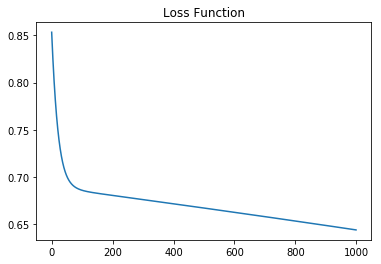

In [0]:
plt.title("Loss Function")
plt.plot(loss_history)
plt.show()

### (4) 결과 확인하기

In [0]:
x1s,x2s = np.mgrid[0:1:0.01,0:1:0.01]
xs2 = np.stack([x1s.ravel(),x2s.ravel()],axis=1)

results = Two.predict(xs2)

colors = []
for result in results.ravel():
    if result > 0.5:
        colors.append('g')
    else:
        colors.append('r')
        
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(xs2[:,0],xs2[:,1],c=colors,alpha=0.1)

# 0: 정상
cancer_df[cancer_df.label==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
cancer_df[cancer_df.label==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(["decision",'Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

(100, 10)


ValueError: ignored

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---